In [3]:
import pathlib
import osmnx
import networkx
import networkx as nx
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List
from clusters import Cluster, ClusterCentreStrategy
from population import PopulationGeneratorConfig, generate_data_points
from traffic import IncrementalBatchRouteAssigner, Route, Time
from travel import TravelGenerator
import pandas as pd
import seaborn as sns
from utils import visualize_clusters, visualize_points, visualize_paths, visualize_weighted_paths, rescale
import folium
from tqdm import tqdm

In [15]:
RESOLUTION = 8
POPULATION_MULTIPLIERS = list(np.linspace(.5, 10., 20))
config = PopulationGeneratorConfig.from_json_file(pathlib.Path("configs/slupsk_2004.json"))
base_population = sum(epi.population_count for epi in config.epicentres)


cluster_centre_strategy = ClusterCentreStrategy.HEXAGON_CENTER
places = [
    'Słupsk, Polska',
    'gmina Słupsk, Polska',
    'gmina Kobylnica, Polska',
]
custom_filter = '["highway"~"motorway|primary|secondary|tertiary"]'
graph = osmnx.graph.graph_from_place(places, network_type="drive", custom_filter=custom_filter)
graph = osmnx.speed.add_edge_travel_times(osmnx.add_edge_speeds(graph))
cluster_graphs = {}
clusters_lists = {}
route_lists = {}
mean_travel_times = {}

In [6]:
@dataclass
class SimulationResults:
    population_count: int
    cluster_graph: nx.MultiDiGraph
    routes: List[Route]
    mean_travel_time: Time
    clusters: List[Cluster]


def simulate(multiplier: float) -> SimulationResults:
    config = PopulationGeneratorConfig.from_json_file(pathlib.Path("configs/slupsk_2004.json"))
    config.multiply_population(multiplier)
    pts_by_epi = {epi.label: generate_data_points(epi) for epi in config.epicentres}
    points = [point for pts in pts_by_epi.values() for point in pts]
    clusters = Cluster.consolidate_clusters(Cluster.clusterize_points(points, RESOLUTION, cluster_centre_strategy), graph, RESOLUTION)
    travels = TravelGenerator(config).generate_travels(clusters)
    assigner = IncrementalBatchRouteAssigner(h3_resolution=8, iterations_count=4, batch_size=10)
    routes = assigner.assign_routes(travels, clusters, graph)
    mean_travel_time = sum([route.estimated_travel_time.minutes for route in routes]) / len([route.estimated_travel_time.minutes for route in routes])
    return SimulationResults(len(points), assigner.graph, routes, mean_travel_time, clusters)

In [17]:
results = [simulate(multiplier) for multiplier in tqdm(POPULATION_MULTIPLIERS)]

  0%|                                                                                                                                                               | 0/4 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [2:22:56<00:00, 428.83s/it]


In [4]:
import pickle

In [7]:
# with open("pickled_data.pkl", "wb") as f:
#     pickle.dump(results, f)
    
with open("pickled_data.pkl", "rb") as f:
    temp = pickle.load(f)

EOFError: Ran out of input

In [11]:
df = pd.DataFrame.from_dict({"multiplier": POPULATION_MULTIPLIERS, "mean_travel_times": mean_travel_times.values()})
df["log_mean_travel_time"] = np.log10(df["mean_travel_times"])
df["population"] = df["multiplier"] * base_population

<Axes: xlabel='population', ylabel='log_mean_travel_time'>

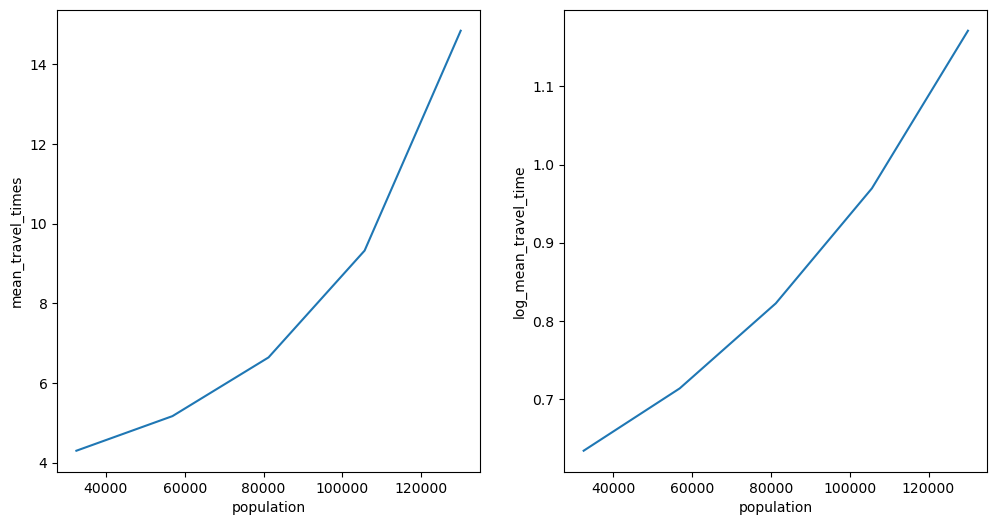

In [12]:
f = plt.figure(figsize=(12, 6))
gs = f.add_gridspec(1, 2)
ax = f.add_subplot(gs[0, 0])
sns.lineplot(x="population", y="mean_travel_times", data=df, ax=ax)
ax = f.add_subplot(gs[0, 1])
sns.lineplot(x="population", y="log_mean_travel_time", data=df, ax=ax)

In [21]:
index = 4
cluster_graph = cluster_graphs[index]

edges_df = pd.DataFrame([
    {
        "start": start, 
        "end": end, 
        "travel_time": state.travel_time.minutes, 
        "free_flow_travel_time": state.path_data.free_flow_travel_time.minutes, 
        "capacity": state.path_data.max_capacity, 
        "volume": len(state.current_volume),
        "path": state.path_data.path,
    } for (start, end, state) in cluster_graph.edges.data("state")
])

edges_df["traffic_slowdown"] = edges_df["travel_time"] - edges_df["free_flow_travel_time"]
edges_df.sort_values("traffic_slowdown")

clusters = clusters_lists[index]
cluster_by_id = {cluster.h3_hex_id: cluster for cluster in clusters}

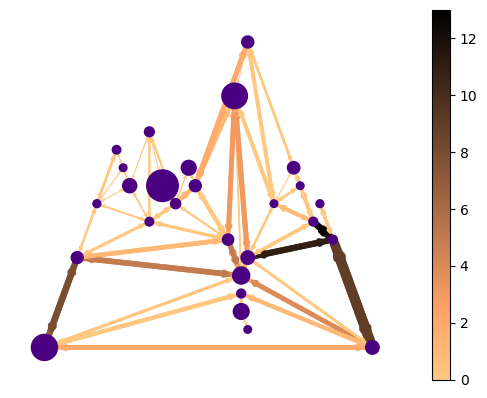

In [22]:
pos = nx.planar_layout(cluster_graph,)

nodelist = cluster_by_id.keys()
cluster_pops = [len(cluster.points) for cluster in cluster_by_id.values()]
node_sizes = [30 + 700*np.log(1 + (pop_count - min(cluster_pops)) / (max(cluster_pops) - min(cluster_pops)) )for pop_count in cluster_pops]

edge_volumes = [
    int(edges_df[(edges_df["start"] == start) & (edges_df["end"] == end)]["volume"]) 
    for (start, end) in cluster_graph.edges
]
widths = [
    .5+10*np.log(1 + (edge_volume - min(edge_volumes)) / (max(edge_volumes) - min(edge_volumes)) )
    for edge_volume in edge_volumes
]

edge_traffic_slowdowns = [
    int(edges_df[(edges_df["start"] == start) & (edges_df["end"] == end)]["traffic_slowdown"]) 
    for (start, end) in cluster_graph.edges
]
edge_colors = edge_traffic_slowdowns
cmap = plt.cm.copper_r

nodes = nx.draw_networkx_nodes(cluster_graph, pos, node_size=node_sizes, node_color="indigo")
ax = plt.gca()
edges = nx.draw_networkx_edges(
    cluster_graph,
    pos,
    ax=ax,
    node_size=node_sizes,
    arrowstyle="->",
    arrowsize=5,
    edge_color=edge_colors,
    edge_cmap=cmap,
    width=widths,
)

pc = mpl.collections.PatchCollection(edges, cmap=cmap)
pc.set_array(edge_colors)
ax.set_axis_off()
plt.colorbar(pc, ax=ax)
plt.show()

In [24]:
cmap = plt.cm.copper_r
edge_traffic_slowdowns = [
    round(row["traffic_slowdown"])
    for _, row in edges_df.iterrows()
]
MIN_SLOWDOWN = 0
MAX_SLOWDOWN = max(30, max(edge_traffic_slowdowns))
colors = [
    mpl.colors.rgb2hex(cmap(rescale(slowdown, old_max=MAX_SLOWDOWN, old_min=MIN_SLOWDOWN, new_max=1, new_min=0)))
    for slowdown in edge_traffic_slowdowns
]
edge_volumes = [
    round(row["volume"])
    for _, row in edges_df.iterrows()
]
MIN_VOLUME = 0
MAX_VOLUME = max(20000, max(edge_volumes))
weights = [
    rescale(volume, old_max=MAX_VOLUME, old_min=MIN_VOLUME, new_max=10, new_min=1) 
    for volume in edge_volumes
]
m = folium.Map(location=[54.46270136314862, 17.019373399360482], zoom_start=13, tiles='cartodbpositron')
visualize_weighted_paths(m, graph, list(edges_df.path), colors, weights)
visualize_clusters(m, clusters, ['green'])
visualize_points(m, [cluster.centre for cluster in clusters], ['green'])
m